In [1]:
# Setup Python path to allow imports from src/
import sys
from pathlib import Path

# Add project root and src directory to Python path
project_root = Path().resolve().parent
src_path = project_root / "src"

for path in [str(project_root), str(src_path)]:
    if path not in sys.path:
        sys.path.insert(0, path)

# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# User Clarification and Brief Generation

*The goal of scoping is to gather user-context needed for research.*

Here is our overall research flow:

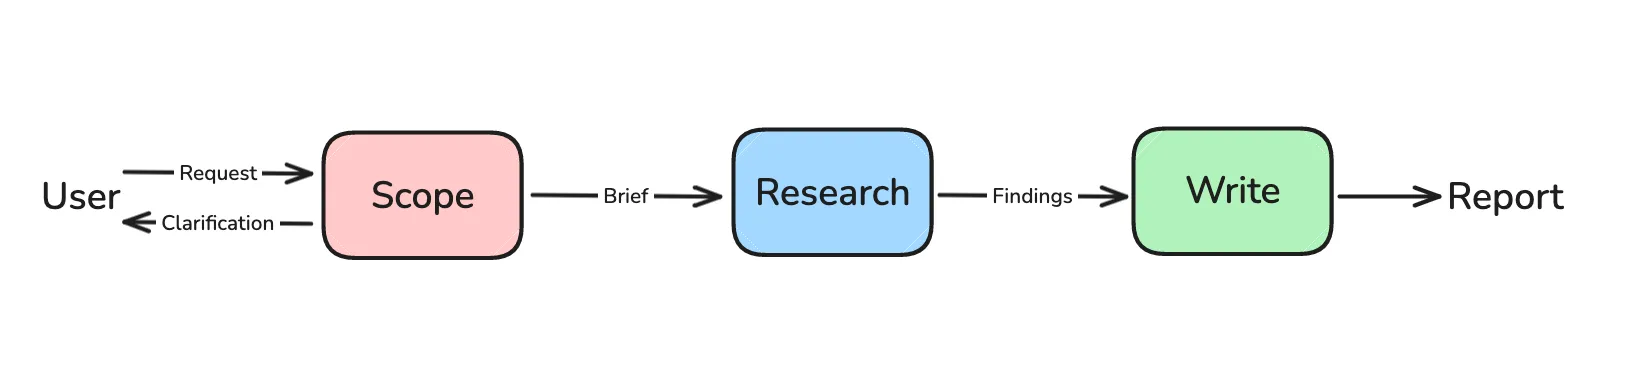

We'll scope the research in two phases:

1. **User Clarification** - Determines if additional clarification is needed from the user
2. **Brief Generation** - Transforms the conversation into a detailed research brief

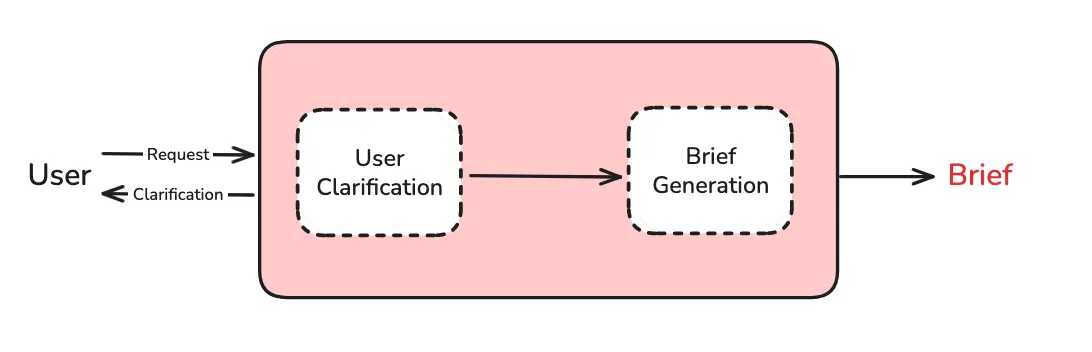

### Prompts

A common challenge in deep research workflows is that users rarely provide sufficient context in their initial request. 

Requests often lack important details like:

- **Scope and boundaries**: What should be included or excluded?
- **Audience and purpose**: Who is this research for and why?
- **Specific requirements**: Are there particular sources, timeframes, or constraints?
- **Clarification of terms**: What do domain-specific terms or acronyms mean?

Rather than making assumptions, we gather additional context through targeted clarification questions. 

This ensures we understand the user's true intent before investing time in research that might miss the mark.

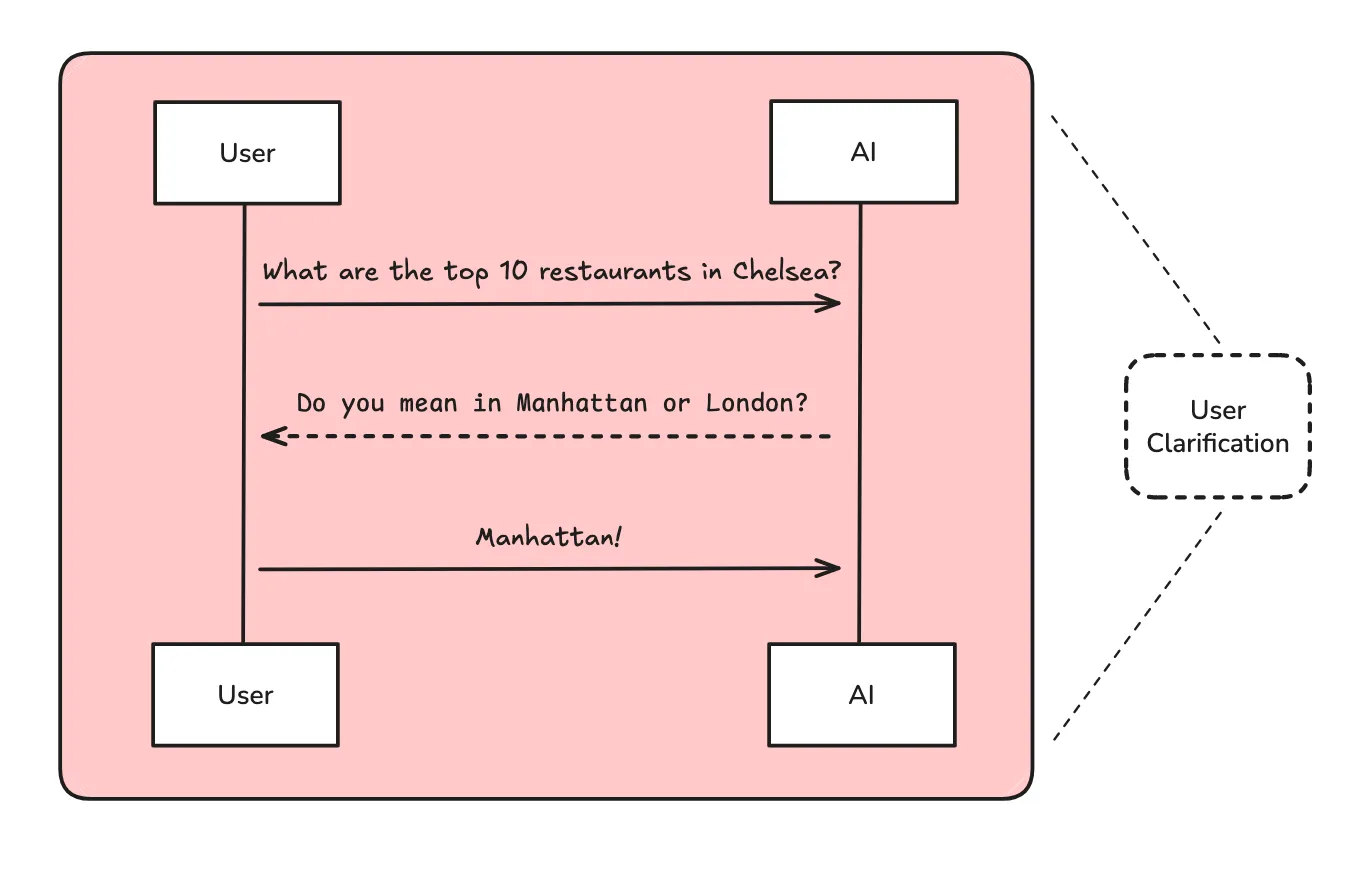

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import clarify_with_user_instructions
show_prompt(clarify_with_user_instructions, "Clarify with User Instructions")

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

### State and Schemas

First, we'll define the state object and schemas for our research process. 

The state object serves as our primary mechanism for storing and passing context between different phases of the research workflow. 

We can use it to [write and select context](https://blog.langchain.com/context-engineering-for-agents/) that will be used to guide the research.
 
> **Note:** We will use `%%writefile` to save the code block to the specific file, `state_scope.py`. This allows us easily re-use it in future notebooks. And, it creates code that can used directly in a deployable LangGraph application!

In [3]:
%%writefile ../src/deep_research_from_scratch/state_scope.py

"""State Definitions and Pydantic Schemas for Research Scoping.

This defines the state objects and structured schemas used for
the research agent scoping workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

# ===== STATE DEFINITIONS =====

class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent research system.
    
    Extends MessagesState with additional fields for research coordination.
    Note: Some fields are duplicated across different state classes for proper
    state management between subgraphs and the main workflow.
    """

    # Research brief generated from user conversation history
    research_brief: Optional[str]
    # Messages exchanged with the supervisor agent for coordination
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Raw unprocessed research notes collected during the research phase
    raw_notes: Annotated[list[str], operator.add] = []
    # Processed and structured notes ready for report generation
    notes: Annotated[list[str], operator.add] = []
    # Final formatted research report
    final_report: str

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""
    
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation."""
    
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

Overwriting ../src/deep_research_from_scratch/state_scope.py


### Scope Research

Now, we'll create a simple workflow to clarify the user's intent and write a research brief.

We'll let the LLM determine whether it has sufficient clarification to write the brief.
 
This will use LangGraph's [Command](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#combine-control-flow-and-state-updates-with-command) to direct the control flow and updating state. The `Command` object takes two key parameters:
- `goto`: Specifies the next node to execute (or `END` to terminate)
- `update`: Dictionary of state updates to apply before transitioning

This pattern allows our functions to both process data and direct the workflow based on their results. 

It creates a more flexible and maintainable system than traditional static graph structures.

In [ ]:
%%writefile ../src/deep_research_from_scratch/research_agent_scope.py

"""User Clarification and Research Brief Generation.

This module implements the scoping phase of the research workflow, where we:
1. Assess if the user's request needs clarification
2. Generate a detailed research brief from the conversation

The workflow uses structured output to make deterministic decisions about
whether sufficient context exists to proceed with research.
"""

from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import clarify_with_user_instructions, transform_messages_into_research_topic_prompt
from deep_research_from_scratch.state_scope import AgentState, ClarifyWithUser, ResearchQuestion, AgentInputState

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

# ===== CONFIGURATION =====

# Initialize model - Primary: Google Gemini | Alternatives: "openai:gpt-4.1", "anthropic:claude-sonnet-4-20250514"

model = init_chat_model(
    model="gemini-2.5-pro",
    model_provider="google_genai",
    temperature=0.0
)

# ===== WORKFLOW NODES =====

def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    """
    Determine if the user's request contains sufficient information to proceed with research.
    
    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation or ends with a clarification question.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    # Route based on clarification need
    if response.need_clarification:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )

def write_research_brief(state: AgentState):
    """
    Transform the conversation history into a comprehensive research brief.
    
    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)
    
    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    
    # Update state with generated research brief and pass it to the supervisor
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

# ===== GRAPH CONSTRUCTION =====

# Build the scoping workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

# Compile the workflow
scope_research = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_scope.py


E0000 00:00:1759396054.000346   11399 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


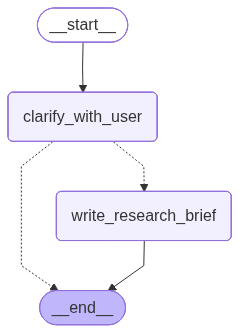

In [7]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_scope import deep_researcher_builder

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [8]:
# Run the workflow
from utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To help me narrow down the search, could you please specify what you mean by 'best'? Are you looking for coffee │
│ shops with the best coffee quality, atmosphere, price, or something else?                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
result = scope.invoke({"messages": [HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To help me narrow down the search, could you please specify what you mean by 'best'? Are you looking for coffee │
│ shops with the best coffee quality, atmosphere, price, or something else?                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Okay, I understand that you want me to research the best coffee shops in San Francisco based on coffee quality. │
│ I will now begin the research process.                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
from rich.markdown import Markdown
Markdown(result["research_brief"])

I want to find the best coffee shops in San Francisco based on coffee quality. Research coffee quality factors     
(including bean sourcing, roasting methods, brewing techniques) for San Francisco coffee shops, with primary focus 
on taste as specified by the user. Consider all price ranges unless cost constraints are specified.

We can look at the [trace](https://smith.langchain.com/public/75278fdf-4468-4dcc-bf44-a28ab6018d92/r).

### Local Deployment and LangGraph Studio

LangGraph is designed to seamlessly support deployment. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during this notebook form the basis of our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

In addition, the repo has a `langgraph.json` file that specifies the dependencies, graphs, and environment variables.

This structure allows the scoping workflow [to be deployed either locally or via a remote server](https://langchain-ai.github.io/langgraph/concepts/deployment_options/).

We can kick off LangGraph server locally with the below command from the root of the repo, which will open LangGraph Studio in our browser:

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev
```